In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm

In [2]:
"""
I prepped my data ahead of time, but all you have to do is pull it down from
statcast (use pybaseball) and then add batter and pitcher names to the dataframe
"""

df_init = pd.read_pickle("ev_df_2024.pkl")

In [3]:
"""
Adding some variables for modeling and for filtering.

Note that you could use a random effect for each platoon combo rather
than a fixed effect for platoon vs not platoon. The world is your oyster.
"""

df_init["platoon_bool"] = (df_init["p_throws"]==df_init["stand"]).astype(int)
df_init["pa"] = (~df_init["woba_value"].isna()).astype(int)
df_init["pitcher_pa"] = df_init[["pitcher","pa"]].groupby(["pitcher"]).transform("sum")
df_init["batter_pa"] = df_init[["batter","pa"]].groupby(["batter"]).transform("sum")

In [4]:
"""
Using a reduced dataframe here to speed up modeling. Once you have the
model parameterized correctly you can run it with the full dataset.
"""

random_batters = list(
    np.random.choice(
        df_init
        .loc[(df_init["batter_pa"]>=300)]
        ["batter"]
        .unique(),
        size=10,
        replace=False,
    )
)

random_pitchers = list(
    np.random.choice(
        df_init
        .loc[(df_init["pitcher_pa"]>=300)]
        ["pitcher"]
        .unique(),
        size=10,
        replace=False,
    )
)

df = (
    df_init
    .loc[(df_init["batter"].isin(random_batters))|(df_init["pitcher"].isin(random_pitchers))]
    .dropna()
    .reset_index(drop=True)
)

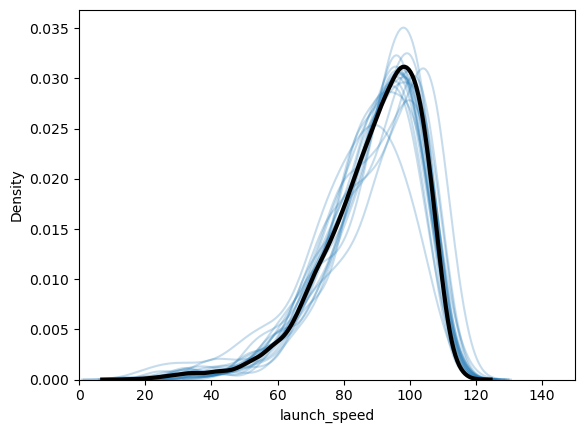

In [5]:
"""
Plotting the EV distributions for the full dataset and for each of the random
batters and each of the random pitchers. This gives us an idea of the spread in
means, variances, and skews we observe in the data to help set up reasonable priors.
"""

for batter in random_batters:
    sns.kdeplot(
        df.loc[(df["batter"]==batter),"launch_speed"],
        color = "C0",
        alpha = 0.25,
    )

for pitcher in random_pitchers:
    sns.kdeplot(
        df.loc[(df["pitcher"]==pitcher),"launch_speed"],
        color = "C0",
        alpha = 0.25,
    )

sns.kdeplot(
    df["launch_speed"],
    color = "black",
    lw = 3,
)

plt.xlim(0,150)

plt.show()

In [6]:
"""
Start with a basic model with no correlated features. Once this is working well, 
then try adding correlated effects.
"""

# Factorize categorical variables
PITCHER_ID, PITCHER = pd.factorize(df["pitcher"])
BATTER_ID, BATTER = pd.factorize(df["batter"])
PLATOON_ID, PLATOON = pd.factorize(df["platoon_bool"])

# Number of unique pitchers and batters
N_PITCHERS = len(df["pitcher"].unique())
N_BATTERS = len(df["batter"].unique())

# Coordinates for the model
coords = {
    "batter": BATTER,
    "pitcher": PITCHER,
    "platoon": PLATOON,
}

with pm.Model(coords=coords) as ev_model:

    ## DATA
    ev = pm.MutableData("ev", df["launch_speed"].to_numpy().astype(np.float32))

    ## PITCHER RANDOM EFFECTS    
    hyper_mean_mu_pitcher = pm.Normal("hyper_mean_mu_pitcher", 0, 1)
    hyper_mean_sigma_pitcher = pm.HalfNormal("hyper_mean_sigma_pitcher", 2.5)
    v_mean_pitcher = pm.Normal("v_mean_pitcher", 0, 1, dims=("pitcher"))
    mean_pitcher = pm.Deterministic("mean_pitcher",hyper_mean_mu_pitcher + hyper_mean_sigma_pitcher * v_mean_pitcher)

    hyper_sigma_mu_pitcher = pm.Normal("hyper_sigma_mu_pitcher", 0, 0.05)
    hyper_sigma_sigma_pitcher = pm.HalfNormal("hyper_sigma_sigma_pitcher", 0.125)
    v_std_pitcher = pm.Normal("v_std_pitcher", 0, 1, dims=("pitcher"))
    std_pitcher = pm.Deterministic("std_pitcher",hyper_sigma_mu_pitcher+hyper_sigma_sigma_pitcher*v_std_pitcher)

    ## BATTER RANDOM EFFECTS
    hyper_mean_mu_batter = pm.Normal("hyper_mean_mu_batter", 0, 1)
    hyper_mean_sigma_batter = pm.HalfNormal("hyper_mean_sigma_batter", 5)
    v_mean_batter = pm.Normal("v_mean_batter", 0, 1, dims=("batter"))
    mean_batter = pm.Deterministic("mean_batter",hyper_mean_mu_batter + hyper_mean_sigma_batter * v_mean_batter)

    hyper_sigma_mu_batter = pm.Normal("hyper_sigma_mu_batter", 0, 0.1)
    hyper_sigma_sigma_batter = pm.HalfNormal("hyper_sigma_sigma_batter", 0.25)
    v_std_batter = pm.Normal("v_std_batter", 0, 1, dims=("batter"))
    std_batter = pm.Deterministic("std_batter",hyper_sigma_mu_batter+hyper_sigma_sigma_batter*v_std_batter)

    hyper_alpha_mu_batter = pm.Normal("hyper_alpha_mu_batter", 0, 0.1)
    hyper_alpha_sigma_batter = pm.HalfNormal("hyper_alpha_sigma_batter", 0.5)
    v_alpha_batter = pm.Normal("v_alpha_batter", 0, 1, dims=("batter"))
    alpha_batter = pm.Normal("alpha_batter",hyper_alpha_mu_batter+hyper_alpha_sigma_batter*v_alpha_batter)

    ## PLATOON EFFECTS
    mean_platoon = pm.Normal("mean_platoon",-0.5,0.25,dims=("platoon"))
    std_platoon = pm.Normal("std_platoon",-0.1,0.1,dims=("platoon"))

    # INTERCEPTS
    mean_intercept = pm.Normal("mean_intercept",107,0.25)
    std_intercept = pm.Normal("std_intercept",3.15,0.05)
    alpha_intercept = pm.Normal("alpha_intercept", 1.75,0.1)

    # LIKELIHOODS
    mean_final = pm.Deterministic(
        "mean_final",
        mean_pitcher[PITCHER_ID] +
        mean_batter[BATTER_ID] +
        mean_platoon[PLATOON_ID] +
        mean_intercept
    )

    std_final = pm.Deterministic(
        "std_final",
        std_pitcher[PITCHER_ID] +
        std_batter[BATTER_ID] +
        std_platoon[PLATOON_ID] +
        std_intercept
    )

    alpha_final = pm.Deterministic(
        "alpha_final",
        alpha_batter[BATTER_ID] +
        alpha_intercept
    )
   
    ev_pred = pm.SkewNormal(
        "ev_pred",
        mu=mean_final,
        sigma=pm.math.exp(std_final),
        alpha=-1*pm.math.exp(alpha_final),
        observed=ev
    )

Sampling: [alpha_batter, alpha_intercept, ev_pred, hyper_alpha_mu_batter, hyper_alpha_sigma_batter, hyper_mean_mu_batter, hyper_mean_mu_pitcher, hyper_mean_sigma_batter, hyper_mean_sigma_pitcher, hyper_sigma_mu_batter, hyper_sigma_mu_pitcher, hyper_sigma_sigma_batter, hyper_sigma_sigma_pitcher, mean_intercept, mean_platoon, std_intercept, std_platoon, v_alpha_batter, v_mean_batter, v_mean_pitcher, v_std_batter, v_std_pitcher]


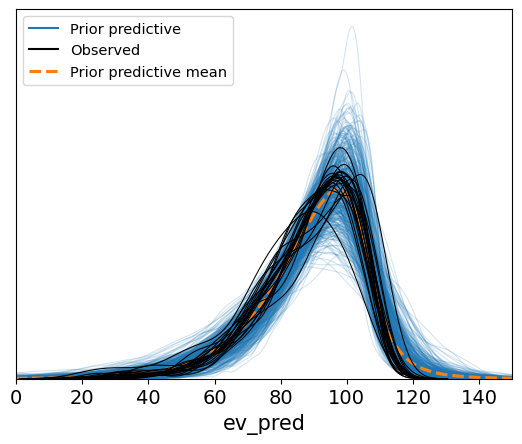

In [7]:
"""
Perform a prior predictive check to make sure your priors are reasonable.
By default arviz just plots the observed mean distribution, so I like to add
some of the individual players' distributions as well.
"""

with ev_model:
    ev_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots()

az.plot_ppc(ev_prior,group="prior",ax=ax,);

for batter in random_batters:
    sns.kdeplot(
        df.loc[(df["batter"]==batter),"launch_speed"],
        color="black",
        lw=0.75,
        ax=ax,
    )

for pitcher in random_pitchers:
    sns.kdeplot(
        df.loc[(df["pitcher"]==pitcher),"launch_speed"],
        color="black",
        lw=0.75,
        ax=ax,
    )

plt.xlim(0,150)

plt.show()

In [8]:
"""
If everything looks good in the previous step you can run the full model.
"""

with ev_model:
    ev_idata = pm.sample(
        500,
        tune=500,
        chains=4, cores=4,
        nuts_sampler="numpyro",
        random_seed=123,
        idata_kwargs={"log_likelihood": True}
    )

with ev_model:
    ev_post = pm.sample_posterior_predictive(ev_idata,extend_inferencedata=False)

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]


Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]


Running chain 3:   0%|          | 0/1000 [00:08<?, ?it/s]

Running chain 1:   5%|▌         | 50/1000 [01:34<27:21,  1.73s/it]

Running chain 0:   5%|▌         | 50/1000 [01:39<28:50,  1.82s/it]


Running chain 0:  10%|█         | 100/1000 [03:17<28:30,  1.90s/it]


Running chain 3:  10%|█         | 100/1000 [03:18<28:36,  1.91s/it]

Running chain 1:  15%|█▌        | 150/1000 [03:31<16:41,  1.18s/it]


Running chain 0:  15%|█▌        | 150/1000 [03:35<16:57,  1.20s/it]

Running chain 2:  15%|█▌        | 150/1000 [03:38<17:20,  1.22s/it]


Running chain 1:  20%|██        | 200/1000 [03:49<11:25,  1.17it/s]

Running chain 1:  25%|██▌       | 250/1000 [04:01<07:54,  1.58it/s]


Running chain 3:  25%|██▌       | 250/1000 [04:02<07:51,  1.59

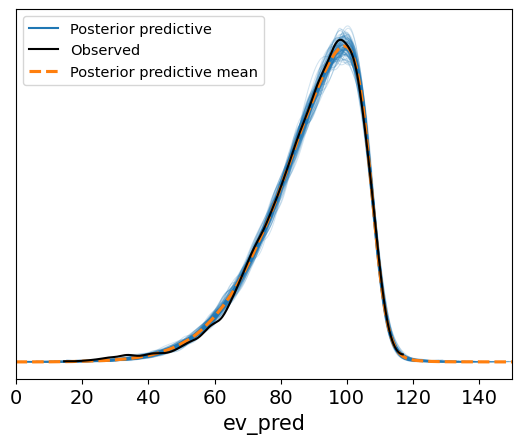

In [9]:
"""
Once it's fitted do a posterior predictive check to make sure everything looks good.
Good idea to also do some trace plots and whatnot, but I'm keeping it simple here.
"""

az.plot_ppc(ev_post,num_pp_samples=100);
plt.xlim(0,150)
plt.show()

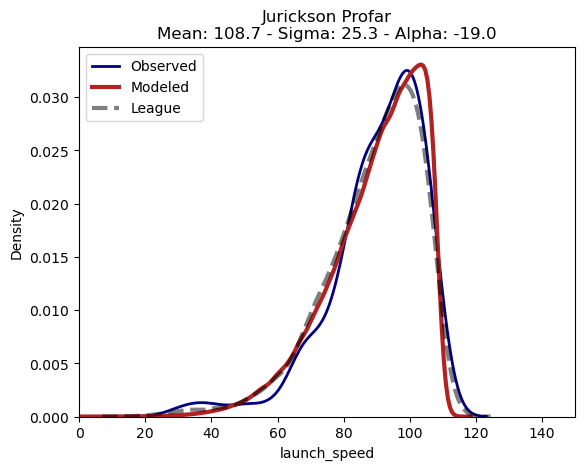

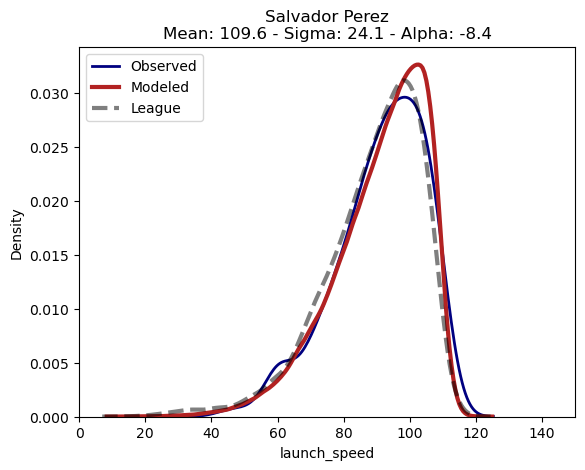

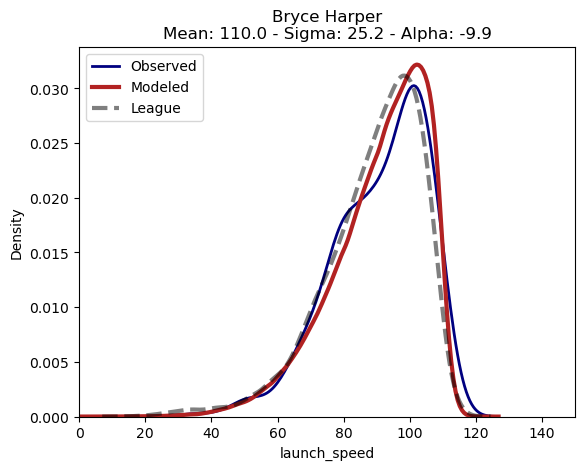

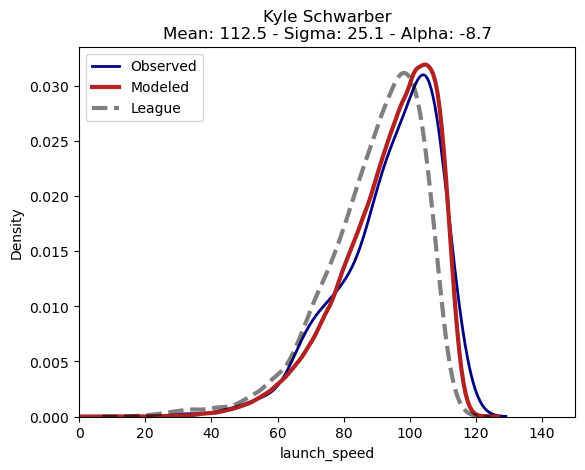

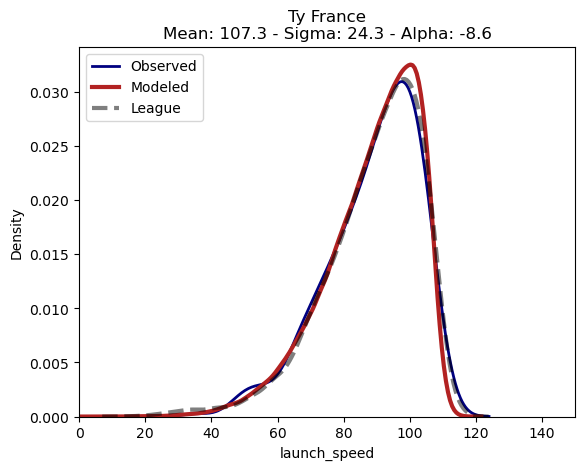

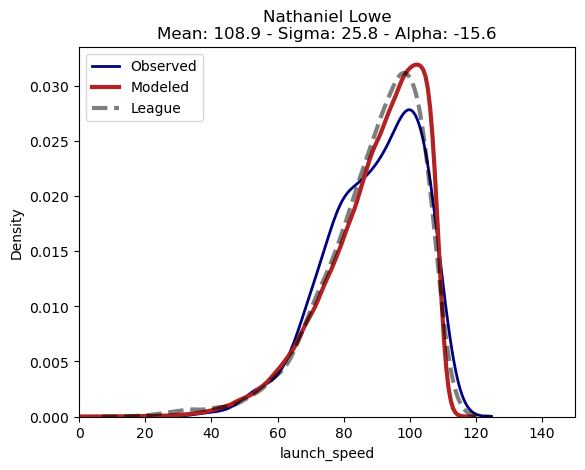

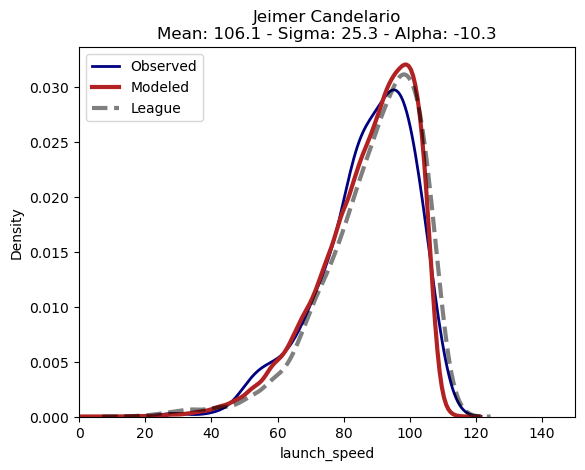

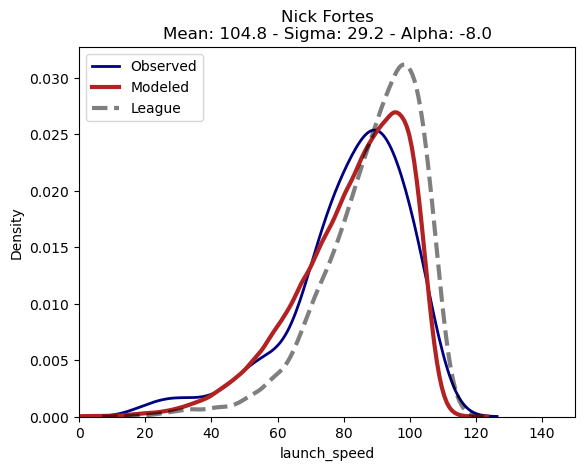

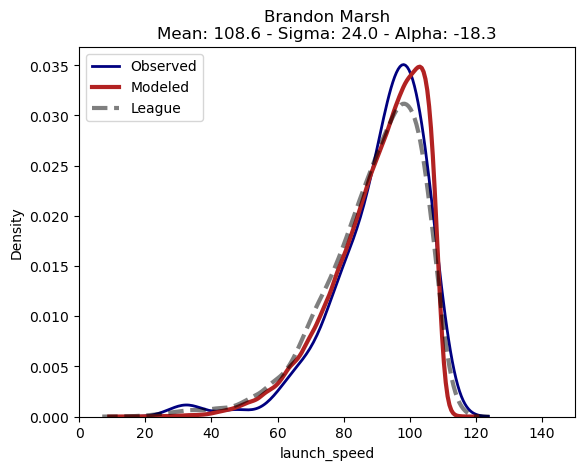

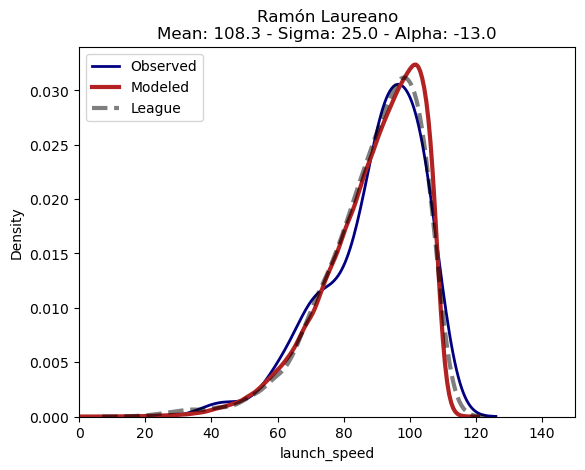

In [10]:
"""
Go through the batters in random batters and check their modeled
distribution vs their observed distribution, and each relative to league.
"""

df["BATTER_ID"] = BATTER_ID
MEAN_INTERCEPT = np.nanmean(ev_idata.posterior.mean_intercept[0,:].data)
STD_INTERCEPT = np.nanmean(ev_idata.posterior.std_intercept[0,:].data)
ALPHA_INTERCEPT = np.nanmean(ev_idata.posterior.alpha_intercept[0,:].data)

for batter in df["BATTER_ID"].value_counts().index[0:10]:

    mean_batter = MEAN_INTERCEPT + np.nanmean(ev_idata.posterior.mean_batter[0,:,batter].data)
    std_batter = np.exp(STD_INTERCEPT + np.nanmean(ev_idata.posterior.std_batter[0,:,batter].data))
    alpha_batter = -1.0 * np.exp(ALPHA_INTERCEPT + np.nanmean(ev_idata.posterior.alpha_batter[0,:,batter].data))

    batter_name = df.loc[(df["BATTER_ID"]==batter),"batter_name"].unique()[0]
   
    sns.kdeplot(
        df.loc[(df["BATTER_ID"]==batter),"launch_speed"],
        color = "navy",
        lw = 2,
        label="Observed",
    )
    sns.kdeplot(
        ev_post.posterior_predictive.ev_pred[0,:,list(df.loc[(df["BATTER_ID"]==batter)].index)].data.flatten(),
        color = "firebrick",
        lw = 3,
        label="Modeled",
    )
    sns.kdeplot(
        df["launch_speed"],
        color = "black",
        lw = 3,
        linestyle="--",
        alpha=0.5,
        label = "League",
    )

    plt.legend(loc="upper left")
    plt.title(f"""{batter_name}
Mean: {mean_batter:.1f} - Sigma: {std_batter:.1f} - Alpha: {alpha_batter:.1f}""")
    plt.xlim(0,150)
    plt.show()

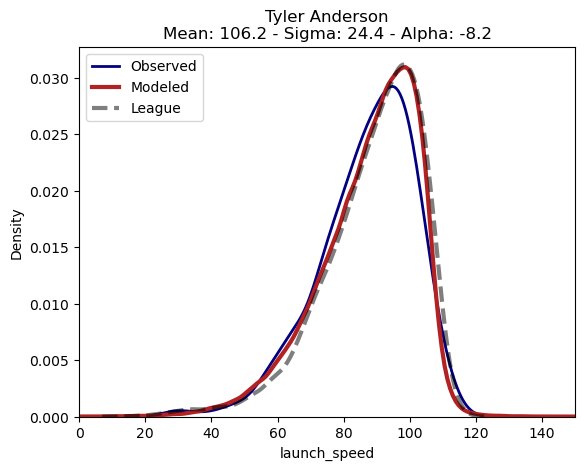

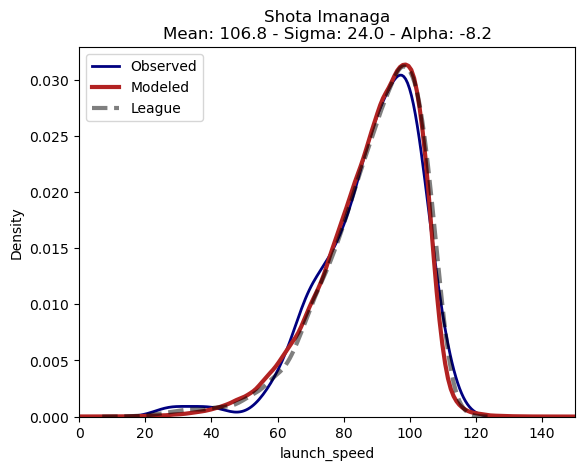

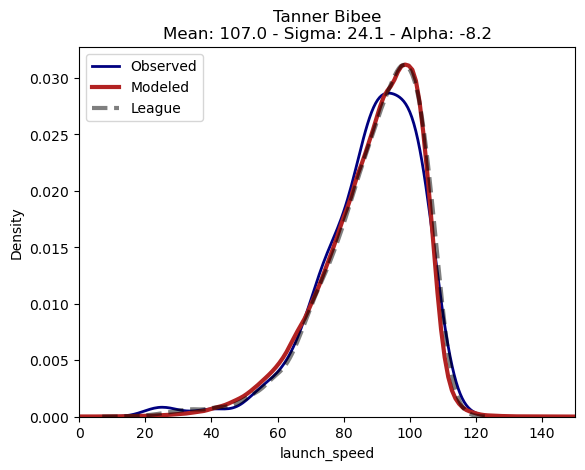

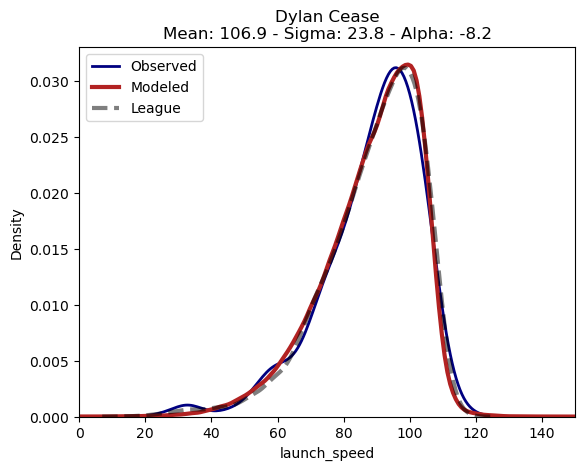

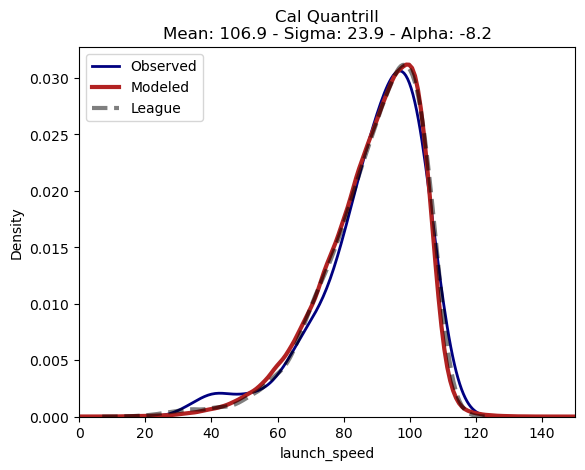

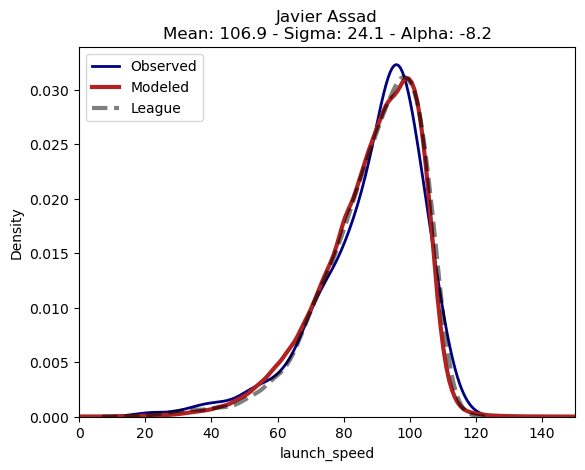

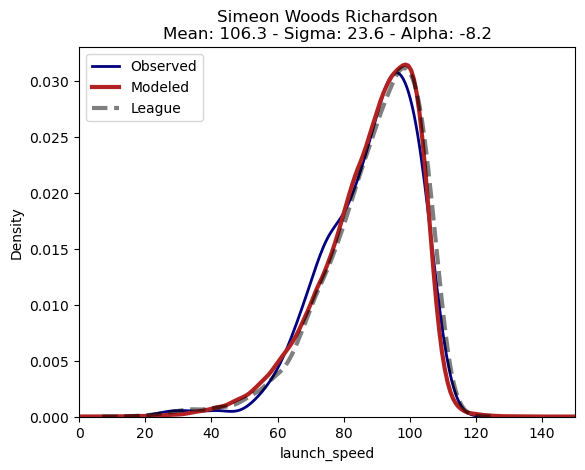

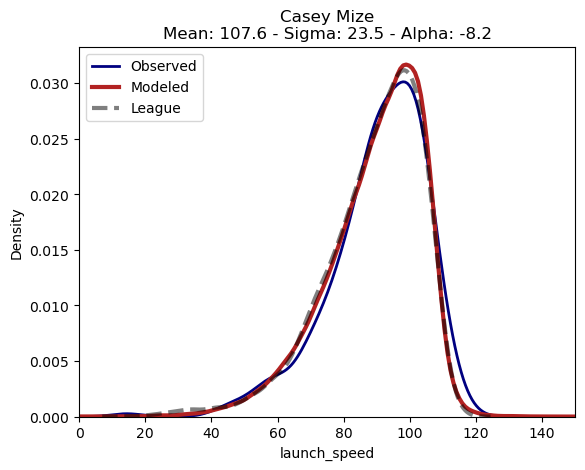

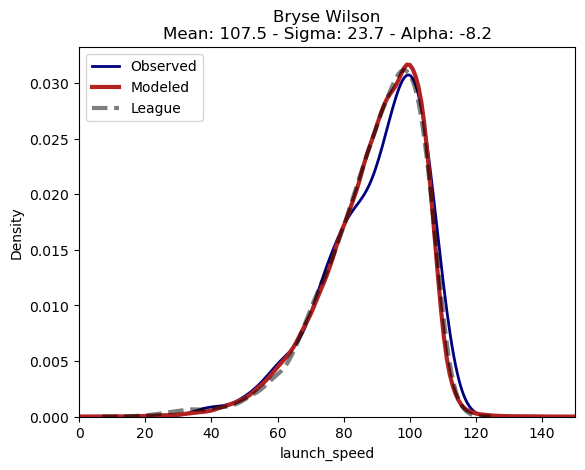

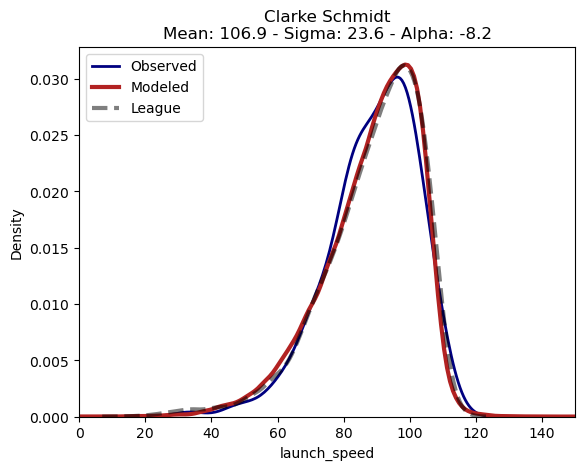

In [11]:
"""
Go through the pitchers in random pitchers and check their modeled
distribution vs their observed distribution, and each relative to league.
"""

df["PITCHER_ID"] = PITCHER_ID
MEAN_INTERCEPT = np.nanmean(ev_idata.posterior.mean_intercept[0,:].data)
STD_INTERCEPT = np.nanmean(ev_idata.posterior.std_intercept[0,:].data)
ALPHA_INTERCEPT = np.nanmean(ev_idata.posterior.alpha_intercept[0,:].data)

for pitcher in df["PITCHER_ID"].value_counts().index[0:10]:

    mean_pitcher = MEAN_INTERCEPT + np.nanmean(ev_idata.posterior.mean_pitcher[0,:,pitcher].data)
    std_pitcher = np.exp(STD_INTERCEPT + np.nanmean(ev_idata.posterior.std_pitcher[0,:,pitcher].data))
    alpha_pitcher = -1.0 * np.exp(ALPHA_INTERCEPT)

    pitcher_name = df.loc[(df["PITCHER_ID"]==pitcher),"pitcher_name"].unique()[0]
   
    sns.kdeplot(
        df.loc[(df["PITCHER_ID"]==pitcher),"launch_speed"],
        color = "navy",
        lw = 2,
        label="Observed",
    )
    sns.kdeplot(
        ev_post.posterior_predictive.ev_pred[0,:,list(df.loc[(df["PITCHER_ID"]==pitcher)].index)].data.flatten(),
        color = "firebrick",
        lw = 3,
        label="Modeled",
    )
    sns.kdeplot(
        df["launch_speed"],
        color = "black",
        lw = 3,
        linestyle="--",
        alpha=0.5,
        label = "League",
    )

    plt.legend(loc="upper left")
    plt.title(f"""{pitcher_name}
Mean: {mean_pitcher:.1f} - Sigma: {std_pitcher:.1f} - Alpha: {alpha_pitcher:.1f}""")
    plt.xlim(0,150)
    plt.show()

In [12]:
"""
Now add correlation between random effects. Note that I'm using a low value for ETA,
assuming some decent correlation. One could play around with this, could add a
pitcher random effect on alpha, etc. Again, the world is your oyster.
"""

# Factorize categorical variables
PITCHER_ID, PITCHER = pd.factorize(df["pitcher"])
BATTER_ID, BATTER = pd.factorize(df["batter"])
PLATOON_ID, PLATOON = pd.factorize(df["platoon_bool"])

# Number of unique pitchers and batters
N_PITCHERS = len(df["pitcher"].unique())
N_BATTERS = len(df["batter"].unique())

# Model parameters
N_CORRELATED_FEATURES_PITCHERS = 2
ETA_PITCHERS = 3

N_CORRELATED_FEATURES_BATTERS = 3
ETA_BATTERS = 3

# Coordinates for the model
coords = {
    "batter": BATTER,
    "pitcher": PITCHER,
    "platoon": PLATOON,
}

with pm.Model(coords=coords) as corr_ev_model:

    ## DATA
    ev = pm.MutableData("ev", df["launch_speed"].to_numpy().astype(np.float32))

    ## PITCHER RANDOM EFFECTS
    chol_pitcher, corr_pitcher, stds_pitcher = pm.LKJCholeskyCov(
        "Rho_pitcher",
        eta=ETA_PITCHERS,
        n=N_CORRELATED_FEATURES_PITCHERS,
        sd_dist=pm.HalfNormal.dist([1,2], size=N_CORRELATED_FEATURES_PITCHERS)
    )

    z_pitcher = pm.Normal("z_pitcher", 0, 1, shape=(N_PITCHERS, N_CORRELATED_FEATURES_PITCHERS))
    v_pitcher = pm.Deterministic("v_pitcher", chol_pitcher.dot(z_pitcher.T).T)
   
    mean_bar_pitcher = pm.Normal("mean_bar_pitcher", 0, 0.25)
    mean_pitcher = pm.Deterministic("mean_pitcher", mean_bar_pitcher + v_pitcher[:, 0])

    std_bar_pitcher = pm.Normal("std_bar_pitcher", 0, 0.1)
    std_pitcher = pm.Deterministic("std_pitcher", std_bar_pitcher + v_pitcher[:, 1])

    ## BATTER RANDOM EFFECTS
    chol_batter, corr_batter, stds_batter = pm.LKJCholeskyCov(
        "Rho_batter",
        eta=ETA_BATTERS,
        n=N_CORRELATED_FEATURES_BATTERS,
        sd_dist=pm.HalfNormal.dist([2.5,2,1], size=N_CORRELATED_FEATURES_BATTERS)
    )

    z_batter = pm.Normal("z_batter", 0, 1, shape=(N_BATTERS, N_CORRELATED_FEATURES_BATTERS))
    v_batter = pm.Deterministic("v_batter", chol_batter.dot(z_batter.T).T)
   
    mean_bar_batter = pm.Normal("mean_bar_batter", 0, 0.5)
    mean_batter = pm.Deterministic("mean_batter", mean_bar_batter + v_batter[:, 0])

    std_bar_batter = pm.Normal("std_bar_batter", 0, 0.1)
    std_batter = pm.Deterministic("std_batter", std_bar_batter + v_batter[:, 1])

    alpha_bar_batter = pm.Normal("alpha_bar_batter", 0, 0.1)
    alpha_batter = pm.Deterministic("alpha_batter", alpha_bar_batter + v_batter[:, 2])

    ## PLATOON EFFECTS
    mean_platoon = pm.Normal("mean_platoon",-0.5,0.25,dims=("platoon"))
    std_platoon = pm.Normal("std_platoon",-0.5,0.1,dims=("platoon"))

    # INTERCEPTS
    mean_intercept = pm.Normal("mean_intercept",107,0.25)
    std_intercept = pm.Normal("std_intercept",23,2.5)
    alpha_intercept = pm.Normal("alpha_intercept",7.5,1.5)

    # LIKELIHOODS
    mean_final = pm.Deterministic(
        "mean_final",
        mean_pitcher[PITCHER_ID] +
        mean_batter[BATTER_ID] +
        mean_platoon[PLATOON_ID] +
        mean_intercept
    )

    std_final = pm.Deterministic(
        "std_final",
        pm.math.log1pexp(
            std_pitcher[PITCHER_ID] +
            std_batter[BATTER_ID] +
            std_platoon[PLATOON_ID] +
            std_intercept
        )
    )

    alpha_final = pm.Deterministic(
        "alpha_final",
        alpha_batter[BATTER_ID] +
        alpha_intercept
    )
   
    ev_pred = pm.SkewNormal(
        "ev_pred",
        mu=mean_final,
        sigma=std_final,
        alpha=-1*alpha_final,
        observed=ev
    )

Sampling: [Rho_batter, Rho_pitcher, alpha_bar_batter, alpha_intercept, ev_pred, mean_bar_batter, mean_bar_pitcher, mean_intercept, mean_platoon, std_bar_batter, std_bar_pitcher, std_intercept, std_platoon, z_batter, z_pitcher]


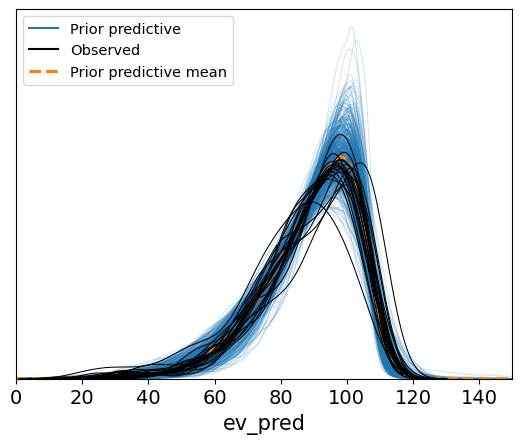

In [13]:
"""
Prior predictive check similar to above.
"""

with corr_ev_model:
    corr_ev_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots()

az.plot_ppc(corr_ev_prior,group="prior",ax=ax,);

for batter in random_batters:
    sns.kdeplot(
        df.loc[(df["batter"]==batter),"launch_speed"],
        color="black",
        lw=0.75,
        ax=ax,
    )

for pitcher in random_pitchers:
    sns.kdeplot(
        df.loc[(df["pitcher"]==pitcher),"launch_speed"],
        color="black",
        lw=0.75,
        ax=ax,
    )

plt.xlim(0,150)

plt.show()

In [14]:
"""
Sample from the correlated model.
"""

with corr_ev_model:
    corr_ev_idata = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        cores=4,
        nuts_sampler="numpyro",
        target_accept=0.95,
        random_seed=123,
        idata_kwargs={"log_likelihood": True}
    )

with corr_ev_model:
    corr_ev_post = pm.sample_posterior_predictive(corr_ev_idata,extend_inferencedata=False)

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/1000 [00:09<?, ?it/s]


Running chain 0:   0%|          | 0/1000 [00:09<?, ?it/s]

Running chain 1:   5%|▌         | 50/1000 [00:45<11:32,  1.37it/s]

Running chain 2:   5%|▌         | 50/1000 [01:18<21:53,  1.38s/it]


Running chain 3:   5%|▌         | 50/1000 [01:25<24:06,  1.52s/it]

Running chain 1:  10%|█         | 100/1000 [01:53<16:23,  1.09s/it]

Running chain 2:  15%|█▌        | 150/1000 [02:01<08:54,  1.59it/s]


Running chain 3:  10%|█         | 100/1000 [02:03<16:09,  1.08s/it]

Running chain 1:  15%|█▌        | 150/1000 [02:12<10:54,  1.30it/s]


Running chain 3:  15%|█▌        | 150/1000 [02:14<09:41,  1.46it/s]

Running chain 2:  25%|██▌       | 250/1000 [02:16<04:13,  2.95it/s]


Running chain 1:  20%|██        | 200/1000 [02:22<07:14,  1.8

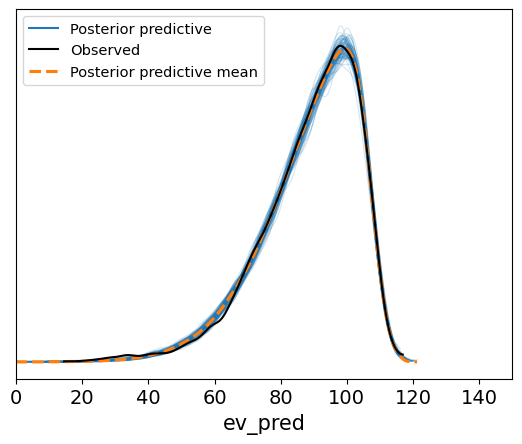

In [15]:
"""
Posterior predictive check on the correlated model.
"""

az.plot_ppc(corr_ev_post,num_pp_samples=100);
plt.xlim(0,150)
plt.show()

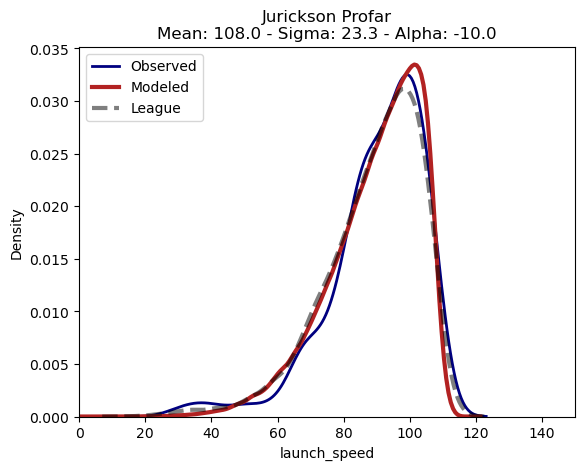

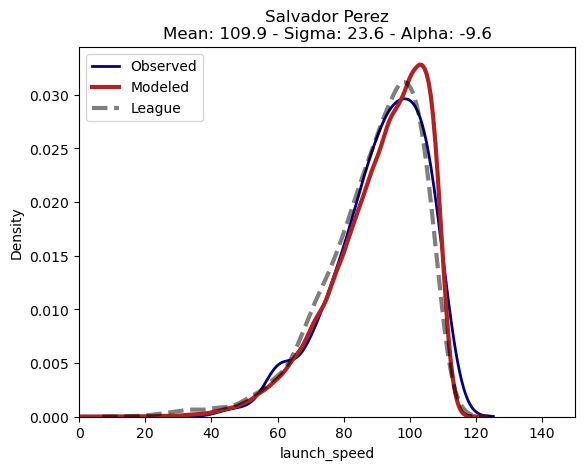

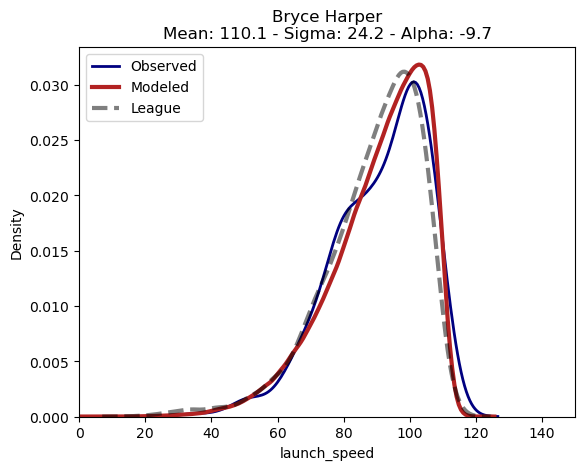

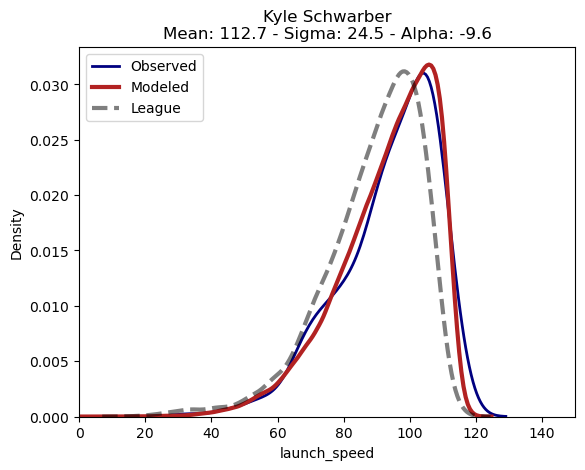

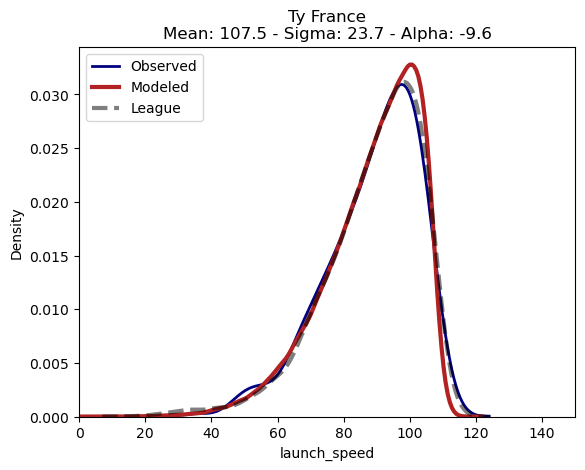

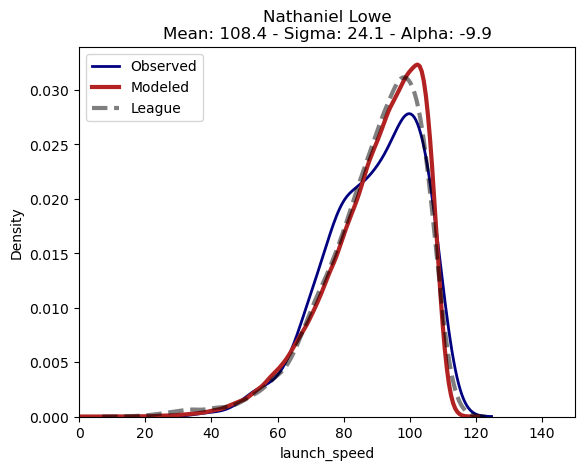

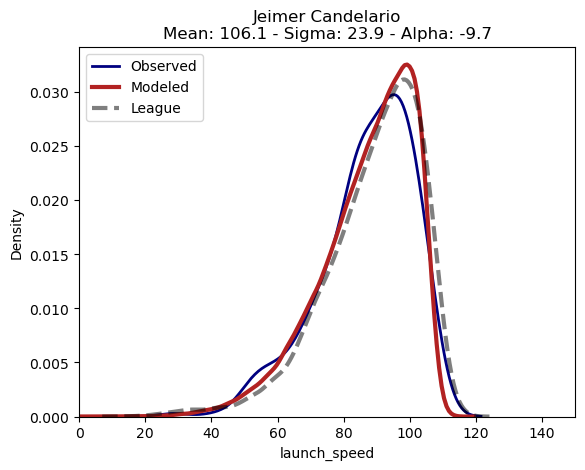

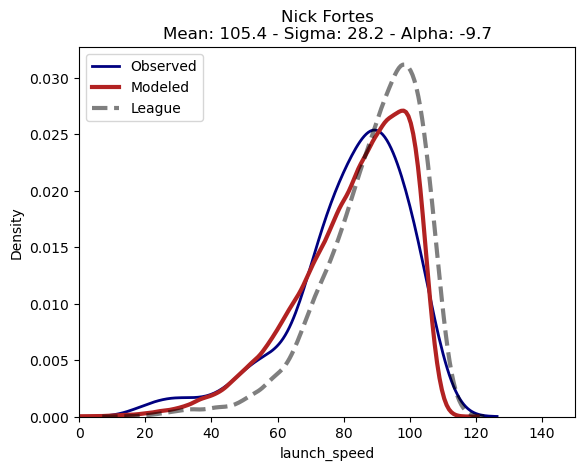

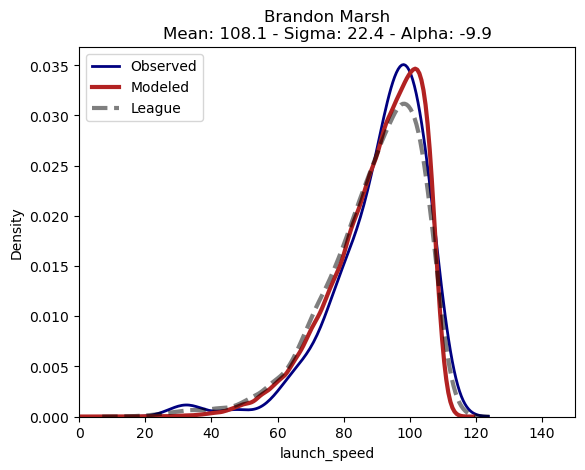

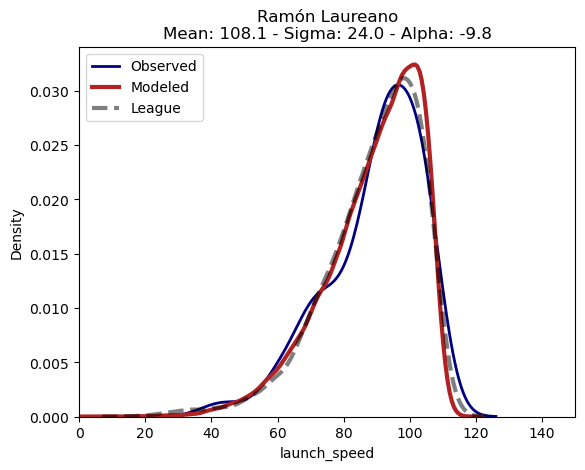

In [16]:
"""
Repeat above for correlated model
"""

df["BATTER_ID"] = BATTER_ID
MEAN_INTERCEPT = np.nanmean(corr_ev_idata.posterior.mean_intercept[0,:].data)
STD_INTERCEPT = np.nanmean(corr_ev_idata.posterior.std_intercept[0,:].data)
ALPHA_INTERCEPT = np.nanmean(corr_ev_idata.posterior.alpha_intercept[0,:].data)

for batter in df["BATTER_ID"].value_counts().index[0:10]:

    mean_batter = MEAN_INTERCEPT + np.nanmean(corr_ev_idata.posterior.mean_batter[0,:,batter].data)
    std_batter = np.log(1+np.exp(STD_INTERCEPT + np.nanmean(corr_ev_idata.posterior.std_batter[0,:,batter].data)))
    alpha_batter = -1.0 * (ALPHA_INTERCEPT + np.nanmean(corr_ev_idata.posterior.alpha_batter[0,:,batter].data))

    batter_name = df.loc[(df["BATTER_ID"]==batter),"batter_name"].unique()[0]
   
    sns.kdeplot(
        df.loc[(df["BATTER_ID"]==batter),"launch_speed"],
        color = "navy",
        lw = 2,
        label="Observed",
    )
    sns.kdeplot(
        corr_ev_post.posterior_predictive.ev_pred[0,:,list(df.loc[(df["BATTER_ID"]==batter)].index)].data.flatten(),
        color = "firebrick",
        lw = 3,
        label="Modeled",
    )
    sns.kdeplot(
        df["launch_speed"],
        color = "black",
        lw = 3,
        linestyle="--",
        alpha=0.5,
        label = "League",
    )

    plt.legend(loc="upper left")
    plt.title(f"""{batter_name}
Mean: {mean_batter:.1f} - Sigma: {std_batter:.1f} - Alpha: {alpha_batter:.1f}""")
    plt.xlim(0,150)
    plt.show()

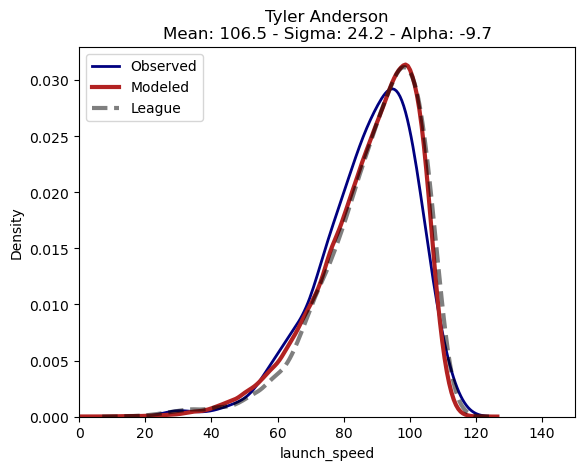

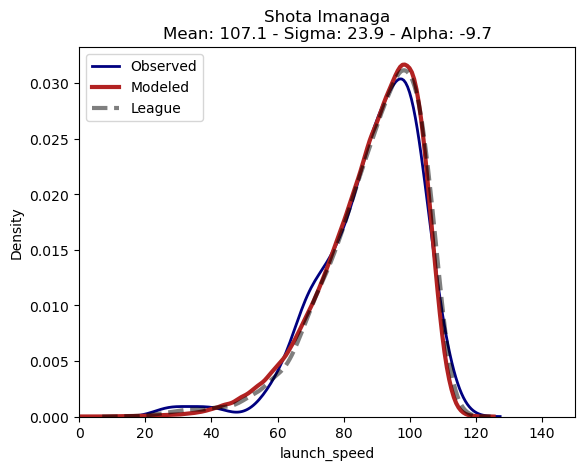

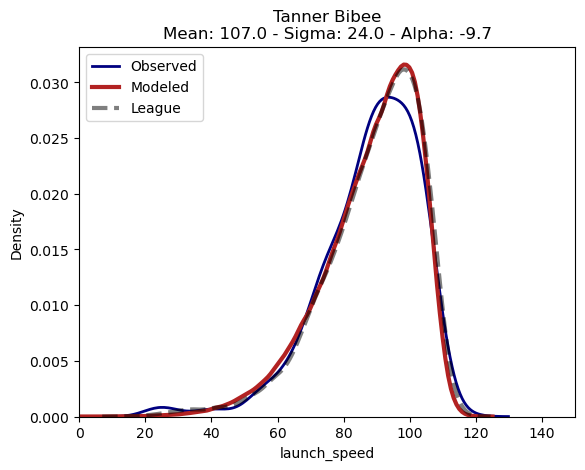

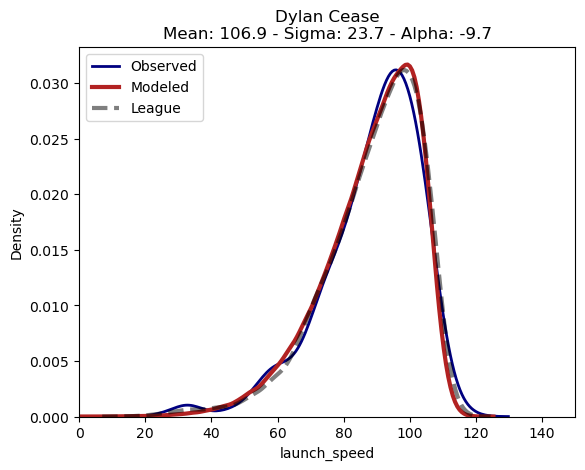

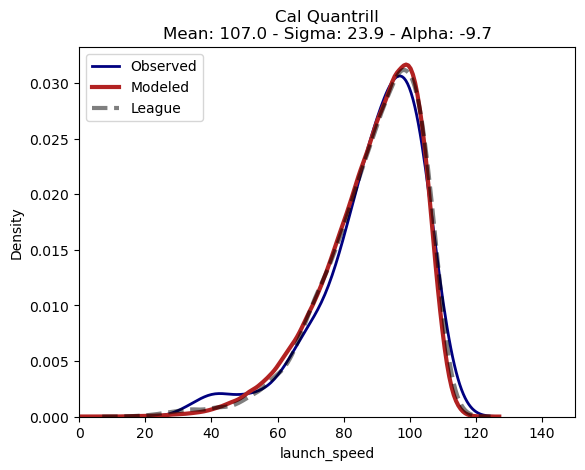

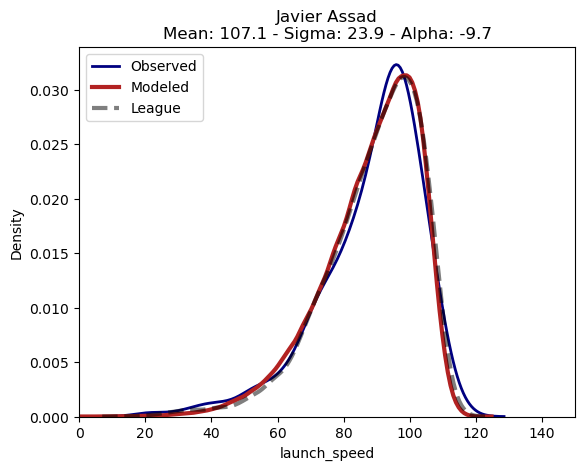

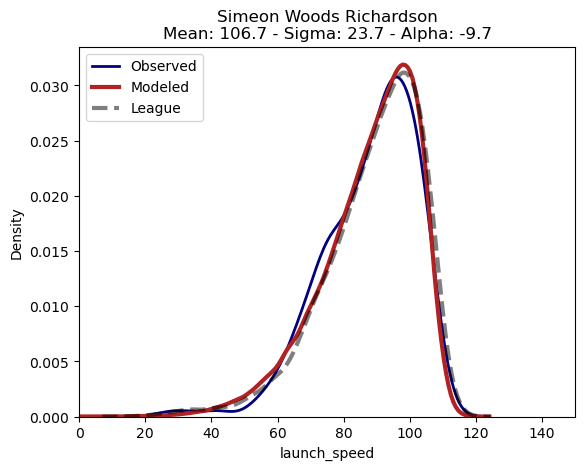

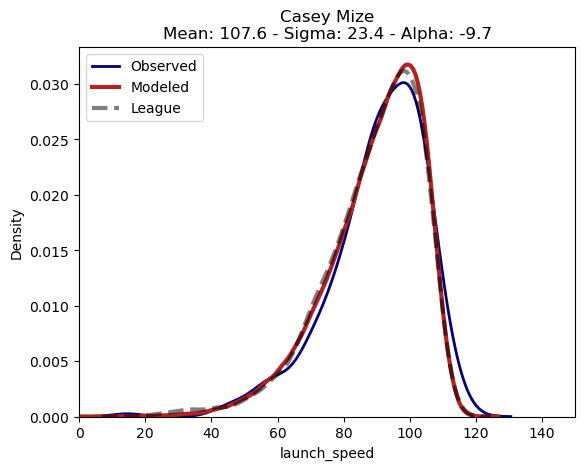

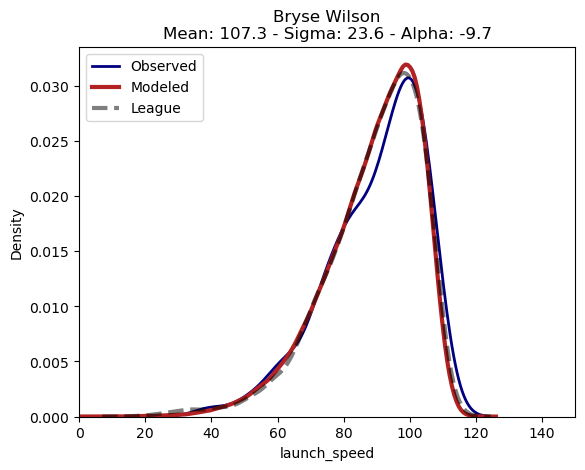

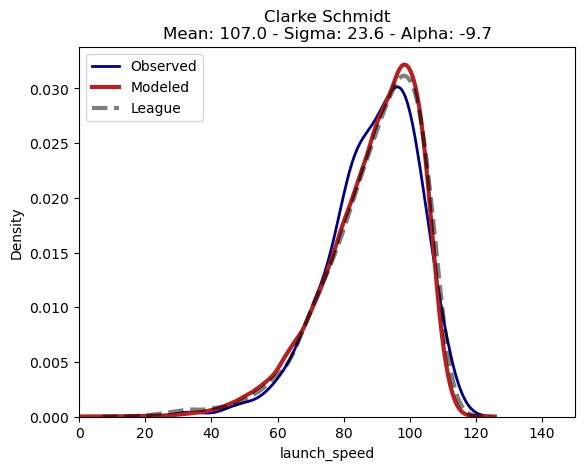

In [17]:
"""
Repeat above for correlated model
"""

df["PITCHER_ID"] = PITCHER_ID
MEAN_INTERCEPT = np.nanmean(corr_ev_idata.posterior.mean_intercept[0,:].data)
STD_INTERCEPT = np.nanmean(corr_ev_idata.posterior.std_intercept[0,:].data)
ALPHA_INTERCEPT = np.nanmean(corr_ev_idata.posterior.alpha_intercept[0,:].data)

for pitcher in df["PITCHER_ID"].value_counts().index[0:10]:

    mean_pitcher = MEAN_INTERCEPT + np.nanmean(corr_ev_idata.posterior.mean_pitcher[0,:,pitcher].data)
    std_pitcher = np.log(1+np.exp(STD_INTERCEPT + np.nanmean(corr_ev_idata.posterior.std_pitcher[0,:,pitcher].data)))
    alpha_pitcher = -1.0 * ALPHA_INTERCEPT

    pitcher_name = df.loc[(df["PITCHER_ID"]==pitcher),"pitcher_name"].unique()[0]
   
    sns.kdeplot(
        df.loc[(df["PITCHER_ID"]==pitcher),"launch_speed"],
        color = "navy",
        lw = 2,
        label="Observed",
    )
    sns.kdeplot(
        corr_ev_post.posterior_predictive.ev_pred[0,:,list(df.loc[(df["PITCHER_ID"]==pitcher)].index)].data.flatten(),
        color = "firebrick",
        lw = 3,
        label="Modeled",
    )
    sns.kdeplot(
        df["launch_speed"],
        color = "black",
        lw = 3,
        linestyle="--",
        alpha=0.5,
        label = "League",
    )

    plt.legend(loc="upper left")
    plt.title(f"""{pitcher_name}
Mean: {mean_pitcher:.1f} - Sigma: {std_pitcher:.1f} - Alpha: {alpha_pitcher:.1f}""")
    plt.xlim(0,150)
    plt.show()

In [ ]:
"""
Some next steps could be:
    -Play around with different priors
    -Use each platoon combo as its own dim
    -Add an alpha effect for pitchers and confirm its negligence
    -Compare correlated vs uncorrelated model performance
    -Plot distribution of batter vs pitcher effects to see who controls what
    -Etc.
"""